<a href="https://colab.research.google.com/github/kate-markina2709/Lab/blob/main/ML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
import re
import nltk
import string
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Работа с данными

In [ ]:
def correct_data(df):
  class_lab_dict = {}
  class_lab_dict['spam'] = int(1)
  class_lab_dict['ham'] = int(0)
  df['target'] = df.category.replace(class_lab_dict)
  return df

In [ ]:
def clean_df(data):
    data = re.sub(r'[^\w\s]', ' ', data)
    sentence_tokens = word_tokenize(data)
    sentence_tokens = [tmp.lower() for tmp in sentence_tokens]
    stopwords = nltk.corpus.stopwords.words('english')
    punctuations = string.punctuation
    tokens = [word for word in sentence_tokens if (word not in punctuations) and (word not in stopwords)]
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

Анализ слов/пар слов

CountVectorizer - токенизирует входные данные и строит словарь известных слов, а затем представляет документ, используя этот словарь

In [ ]:
def word_analysis(data, ng_range, key):
  vectorizer = CountVectorizer(analyzer='word', ngram_range=ng_range)
  ngram = vectorizer.fit_transform(data)
  word_count = ngram.toarray().sum(axis=0)
  dict_ = vectorizer.vocabulary_
  if key == 1:
    result = pd.DataFrame(sorted([(word_count[i], count) for count, i in dict_.items()], reverse=True)).rename(columns=
                                                                                                               {0: "number of repetitions", 1: "word"})
  else:
    result = pd.DataFrame(sorted([(word_count[i], count) for count, i in dict_.items()], reverse=True)).rename(columns=
                                                                                                               {0: "number of repetitions", 1: "phrase"})
  return result

In [ ]:
data_filename = "spam.csv"
df = pd.read_csv(data_filename, sep=',', encoding='latin-1')
df = df.rename(columns={'v1':'category', 'v2':'text'})
df.drop(labels=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df = correct_data(df)
df['tokens'] = df['text'].apply(clean_df)
df.head()

,category,text,target,tokens
0,ham,"Go until jurong point, crazy.. Available only ...",0,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,0,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,0,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,"[nah, think, go, usf, life, around, though]"


In [ ]:
v1 = word_analysis(list(df['text']), (1,1), 1)
v1

,number of repetitions,word
0,2242,to
1,2240,you
2,1328,the
3,979,and
4,898,in
...,...,...
8667,1,0125698789
8668,1,01223585236
8669,1,0121
8670,1,0089


In [ ]:
v2 = word_analysis(list(df['text']), (2,2), 0)
v2

,number of repetitions,phrase
0,276,lt gt
1,180,are you
2,129,you are
3,118,you have
4,109,do you
...,...,...
41649,1,0121 2025050
41650,1,0089 my
41651,1,000pes so
41652,1,000 price


Деление на пары слов каждого предложения

In [ ]:
def to_pair(data_val):
    pair_mas = []
    for i in range(0, len(data_val)-1):
        tmp = data_val[i]+data_val[i + 1]
        pair_mas.append(tmp)
    return pair_mas

Если дальше надо работать с парами, а не просто со словами:

In [ ]:
df['tokens'] = df['tokens'].apply(to_pair)

TF-IDF

In [ ]:
def compute_TF(text):
  dict_text = dict.fromkeys(text, 0)
  for word in dict_text:
    val = text.count(word)/len(text)
    dict_text[word] = val
  return dict_text

In [ ]:
def compute_IDF():
  dict_=[]
  text_val = dict.fromkeys(list(range(0, df.shape[0])), 0)
  for i in range(0, df.shape[0]):
    dict_ = set(dict_).union(set(df['tokens'].loc[i]))
    text_val[i] = df['tokens'].loc[i]
  all_words = dict.fromkeys(dict_, 0)
  for val in all_words:
    n = 0
    for i in text_val:
      if val in text_val[i]:
        n = n + 1
    all_words[val] = math.log(df.shape[0] / float(n))
  return all_words

In [ ]:
def compute_TF_IDF(sentense):
  tf_val = compute_TF(sentense)
  vect = []
  for word in tf_val:
    vect.append(tf_val[word] * idf[word])
  return vect

In [ ]:
idf = compute_IDF()
#idf

In [ ]:
df['TF_IDF'] = df['tokens'].apply(compute_TF_IDF)

In [ ]:
# check
df.head()

,category,text,target,tokens,TF_IDF
0,ham,"Go until jurong point, crazy.. Available only ...",0,"[gojurong, jurongpoint, pointcrazy, crazyavail...","[0.5750339556599797, 0.5750339556599797, 0.575..."
1,ham,Ok lar... Joking wif u oni...,0,"[oklar, larjoking, jokingwif, wifu, uoni]","[1.4478429947559612, 1.7251018669799394, 1.725..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,"[freeentry, entry2, 2wkly, wklycomp, compwin, ...","[0.2438716921941631, 0.2494355002201849, 0.330..."
3,ham,U dun say so early hor... U c already then say...,0,"[udun, dunsay, sayearly, earlyhor, horu, uc, c...","[0.767575335638962, 0.9915452692924689, 1.0781..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,"[nahthink, thinkgo, gousf, usflife, lifearound...","[1.4375848891499494, 1.2544828410385978, 1.437..."


Деление на обучающие и тестовые (соблюдая соотношение в каждом из классов) + преобразование данных из листа в матрицу (TF-IDF для каждого слова в предложении)

iloc - условно, конкретная строка словаря превращается в массив

In [ ]:
def correct_val():
    mat = np.zeros((df.shape[0], max(df['TF_IDF'].apply(len))))
    for i in range(0, df.shape[0]):
        tfidf_val = df['TF_IDF'].iloc[i]
        for j in range(0, len(tfidf_val)):
            mat[i][j] = tfidf_val[j]
    return pd.DataFrame(mat)

data_correct = correct_val()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data_correct, df.target.values, test_size=0.2, random_state=100, stratify=df.target.values)

*Оценка классификатора - матрица ошибок* ([TN FN] [FP TP])

*Метрики - Precision и Recall*

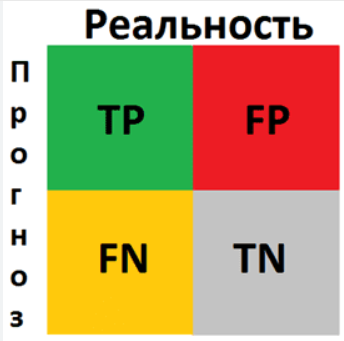

precision = TP/(FP+TP)

recall = TP/(TP+FN)

In [ ]:
def TP(y_true,y_predict):
    return np.sum((y_true==1)&(y_predict==1))

def FP(y_true,y_predict):
    return np.sum((y_true==0)&(y_predict==1))
 
def FN(y_true,y_predict):
    return np.sum((y_true==1)&(y_predict==0))

Обучение и тестирование (логистическая регрессия)

In [ ]:
logreg_clf = LogisticRegression(random_state=15)
logreg_clf.fit(X_train, Y_train)
logreg_predict = logreg_clf.predict(X_test)
logreg_matrix = confusion_matrix(Y_test, logreg_predict)

In [ ]:
logreg_matrix

array([[913,  53],
       [ 75,  74]])

In [ ]:
TP_val_lr = TP(Y_test, logreg_predict)
FP_val_lr = FP(Y_test, logreg_predict)
FN_val_lr = FN(Y_test, logreg_predict)

In [ ]:
precision_lr = TP_val_lr / (FP_val_lr + TP_val_lr)
recall_lr = TP_val_lr / (TP_val_lr + FN_val_lr)
print("Precision val: ", precision_lr)
print("Recall val: ", recall_lr)

Precision val:  0.5826771653543307
Recall val:  0.4966442953020134


Обучение и тестирование (наивный Байес)

In [ ]:
naivbay_clf = GaussianNB()
naivbay_clf.fit(X_train, Y_train)
naivbay_predict = naivbay_clf.predict(X_test)
naivbay_matrix = confusion_matrix(Y_test, naivbay_predict)

In [ ]:
naivbay_matrix

array([[  9, 957],
       [  1, 148]])

In [ ]:
TP_val_nb = TP(Y_test, naivbay_predict)
FP_val_nb = FP(Y_test, naivbay_predict)
FN_val_nb = FN(Y_test, naivbay_predict)

In [ ]:
precision_nb = TP_val_nb / (FP_val_nb + TP_val_nb)
recall_nb = TP_val_nb / (TP_val_nb + FN_val_nb)
print("Precision val: ", precision_nb)
print("Recall val: ", recall_nb)

Precision val:  0.1339366515837104
Recall val:  0.9932885906040269


Обучение и тестирование (метод опорных в-в)

In [ ]:
svm_clf = svm.SVC()
svm_clf.fit(X_train, Y_train)
svm_predict = svm_clf.predict(X_test)
svm_matrix = confusion_matrix(Y_test, svm_predict)

In [ ]:
svm_matrix

array([[903,  63],
       [ 61,  88]])

In [ ]:
TP_val_svm = TP(Y_test, svm_predict)
FP_val_svm = FP(Y_test, svm_predict)
FN_val_svm = FN(Y_test, svm_predict)

In [ ]:
precision_svm = TP_val_svm / (FP_val_svm + TP_val_svm)
recall_svm = TP_val_svm / (TP_val_svm + FN_val_svm)
print("Precision val: ", precision_svm)
print("Recall val: ", recall_svm)

Precision val:  0.5827814569536424
Recall val:  0.5906040268456376
